# Plotting Summary
Sherry Wong, 9 June 2021


This notebook serves the purpose of consolidating all code from Fall 2020-2021.

## 1. Plotting in Matplotlib

### 1.1 Read/load files
#### Save as .csv

### 1.2 Coordinate Setup
### 1.3 Data Setup
### 1.4 Zooming
### 1.5 Velocity Vector Fields

## 2. Plotting with YT
### 2.1 Zooming (w/ + w/o Cut Regions)
### 2.2 Velocity Vector Fields
### 2.3 Streamlines
### 2.4 Making gifs
### 2.5 Total Mass

### Import relevant packages:

In [2]:
import yt
from yt.units import kpc #for yt unit

import os #for file navigation
import os.path
from os import path

import shutil #remove excess files
import time #record runtime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm #for log scale

import moviepy #for gif making
from moviepy.editor import ImageSequenceClip #for gif making
import beepy #sound for when the code is done running
import numpy as np #for working with numbers


## 1. Plotting in Matplotlib
### 1.1 Read/load files:

In [2]:
import h5py

#This method reads in a file, and creates a dictionary of relevant variables.
def fileInputTest(fileName):
    f2 = h5py.File(fileName, 'r')

    print("\nReading file:")
    print(f2) #general info
    print(f2.attrs)
    print("\nKeys:")
    print(f2.keys())
    print()

    coords = f2['coordinates']
    cray = f2['cray']
    dens = f2['dens']
    magx = f2['magx']
    magy = f2['magy']
    magz = f2['magz']
    pres = f2['pres']
    velx = f2['velx']
    vely = f2['vely']
    velz = f2['velz']
    temp = f2['temp']

    dict = {
        "coordinates" : coords,
        "cray_pressure" : cray,
        "density" : dens,
        "magx" : magx,
        "magy" : magy,
        "magz" : magz,
        "pressure" : pres,
        "velx" : velx,
        "vely" : vely,
        "velz" : velz,
        "temp" : temp

    }
    return dict
    #END OF METHOD

#Full file path. Jupyter likes Windows notation, Spyder likes Mac/Linux
#Change the filename to see a different simulation time
filename = r"C:\Users\wongb\Documents\URS Data\m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_0076"
#filename = "/mnt/c/Users/wongb/Documents/URS Data/m1.5_c1_16x16_128x128_Rodrigues_Streaming/More Plot Files/parkerCRs_hdf5_plt_cnt_0000"

dict = fileInputTest(filename)

#print(dict)
#print(dict['density'])


Reading file:
<HDF5 file "parkerCRs_hdf5_plt_cnt_0076" (mode r)>
<Attributes of HDF5 object at 2690510183216>

Keys:
<KeysViewHDF5 ['bflags', 'block size', 'bounding box', 'coordinates', 'cray', 'dens', 'gid', 'gsurr_blks', 'integer runtime parameters', 'integer scalars', 'logical runtime parameters', 'logical scalars', 'magx', 'magy', 'magz', 'node type', 'pres', 'processor number', 'real runtime parameters', 'real scalars', 'refine level', 'sim info', 'string runtime parameters', 'string scalars', 'temp', 'unknown names', 'velx', 'vely', 'velz', 'which child']>



#### Save as .csv if necessary
Commented out b/c data arrays haven't yet been initialised in the notebook, which will cause an error.

In [3]:
import csv #https://docs.python.org/3/library/csv.html#csv.Dialect

#write files for easier access later
#with open('m2_c1_0000_data.csv', 'w', newline='') as csvfile:
# fieldnames = ['posx', 'posy', 'velx', 'vely', 'mag', 'density']
# writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
# writer.writeheader()

# for i in range(0, 262143):
#     writer.writerow({'posx': posXarray[i], 'posy': posYarray[i], 
#                      'velx': velXarray[i], 'vely': velYarray[i], 
#                      'mag': color[i], 'density': densityArray[i]})

### 1.2 Coordinate Setup
#### Prelude:

The coordinate system for the FLASH simulation is a Z-order curve. It doesn't matter too much for our purposes, but it looks cool:

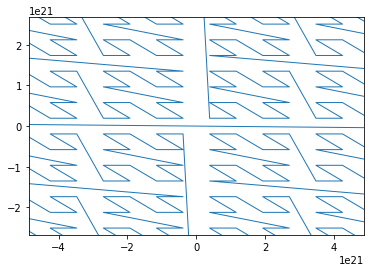

In [4]:
#recreate the z-order curve:
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
plt.plot(posX, posY, linewidth = 1)
plt.margins(x=-0.4, y=-0.39) #zoom
#plt.savefig('CoordPlot1.png'); #bad quality
#plt.savefig('CoordPlot1.svg'); #much better quality
###print("\nPlotting finished.")

#### Expanding coordinate grid

<img src="Data_8x8.png" width="300" style="float: right; padding-left: 30px">

The way that the data is set up, each single coordinate represents a 8x8 box of additional data points. Thus, in order to view the full resolution, it is necessary to expand the each coordinate into an 8x8 grid, with the original coordinate in the bottom left corner. The other data will populate these 8x8 grids.


Without this extra work, plots will be much less resolved:

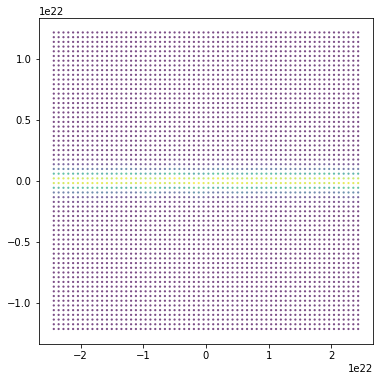

In [5]:
#First convert the HDF5 data into lists
posX = [] #list
posY = [] #list
for coord in dict['coordinates']:
    posX.append(coord[0])
    posY.append(coord[1])
    
density = [] #list
for dens in dict['density']:
     #a random point in the 8x8
    density.append(dens[0][4][4])
    
fig = plt.figure(figsize=(6, 6))
plt.scatter(posX, posY,
           linewidths=0, alpha=.7,
           edgecolor='k',
           s = 5,
           c=density)

#### Coordinate Setup Code
Lets do this properly. 

For each single XY point, we will create an 8x8 grid with the specified point in the bottom left (see image in expanding coordinate grid). Then we will flatten the grid to get two 1D XY arrays. We will calculate the offset based on the position of neighboring cells.

In [6]:
"""Sets up coordinates for 16384 * 64 data points."""
posX = [] #list
posY = [] #list
#these steps may differ between simulations
stepX = dict['coordinates'][1][0] - dict['coordinates'][0][0]
stepY = dict['coordinates'][2][1] - dict['coordinates'][1][1]

for coord in dict['coordinates']:
    
    #equally space x and y apart
    tempXlin = np.linspace(coord[0], coord[0] + stepX, 8)
    tempYlin = np.linspace(coord[1], coord[1] + stepY, 8)
    
    #create a grid of coordinates using these XY values
    tempMeshgrid = np.meshgrid(tempXlin, tempYlin)
    
    #append the full X and Y coordinate pairs
    posX.append(tempMeshgrid[0])
    posY.append(tempMeshgrid[1])
    
posXarray, posYarray = (np.asarray(posX), np.asarray(posY))
posXarray = posXarray.flatten()
posYarray = posYarray.flatten()

### 1.3 Data Setup
Now let's set up the actual data and load them into arrays. These don't require extra work; they are already expanded.

In [7]:
"""Density Setup"""
density = [] #list
for dens in dict['density']:
    density.append(dens) #shape=(1, 8, 8)
densityArray = np.asarray(density)
densityArray = densityArray.flatten()

""""Temp Setup"""
temp = [] #list
for thing in dict['temp']:
    temp.append(thing) #shape=(1, 8, 8)
tempArray = np.asarray(temp)
tempArray = tempArray.flatten()

"""Velocity Setup"""
velX = []
velY = []
for x in dict['velx']:
    velX.append(x)
for y in dict['vely']:
    velY.append(y)
velXarray = np.asarray(velX)
velYarray = np.asarray(velY)
velXarray = velXarray.flatten()
velYarray = velYarray.flatten()

Now we are ready to plot our data.

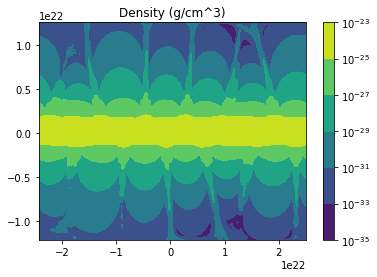

In [8]:
plt.title("Density (g/cm^3)")
plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

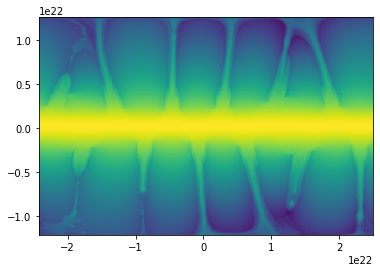

In [9]:
z=densityArray
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarray, posYarray, z, locator=ticker.LogLocator(), levels = lev) #good for irregular Z values

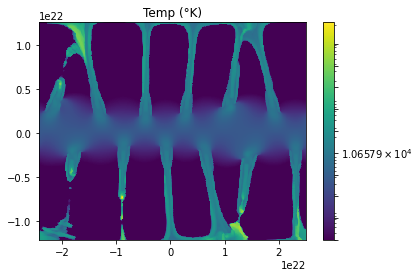

In [10]:
z=tempArray
plt.title("Temp (\N{DEGREE SIGN}K)")
# plt.title("Density (g/$cm^3$)")

lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarray, posYarray, z, locator=ticker.LogLocator(), levels = lev) #good for irregular Z values
plt.colorbar(extend='both', orientation='vertical')

### 1.4 Zooming in matplotlib
We can zoom into particular sections of a plot by applying limits to the data.

In [11]:
#The true/false table
TFtable = np.logical_and((pow(10, 22) < posXarray), (posYarray < 0))

#apply the true/false table to our data.
posXarrayZoom = posXarray[TFtable]
posYarrayZoom = posYarray[TFtable]
velXarrayZoom = velXarray[TFtable]
velYarrayZoom = velYarray[TFtable]
densityArrayZoom = densityArray[TFtable]
tempArrayZoom = tempArray[TFtable]

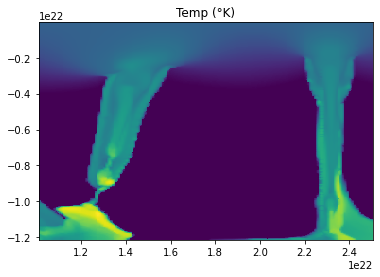

In [12]:
z=tempArrayZoom
plt.title("Temp (\N{DEGREE SIGN}K)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

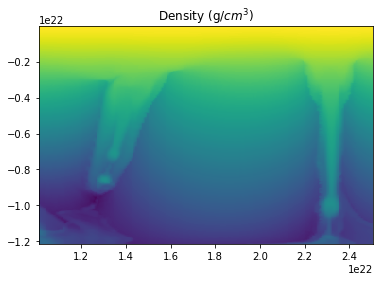

In [13]:
z=densityArrayZoom
plt.title("Density (g/$cm^3$)")
lev = np.logspace(np.log10(z.min()), np.log10(z.max()), num=1000)
plt.tricontourf(posXarrayZoom, posYarrayZoom, z, locator=ticker.LogLocator(), levels = lev)

### 1.5 Velocity Vector Plots
Matplotlib has a built-in way to make vector plots.

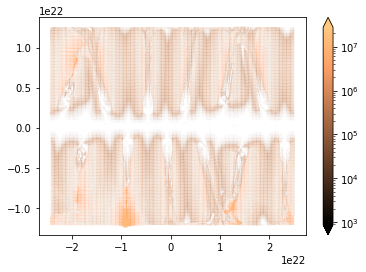

In [14]:
plt.clf
color = np.hypot(velXarray, velYarray)
#plt.tricontourf(posXarray, posYarray, densityArray, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarray, posYarray, velXarray, velYarray, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

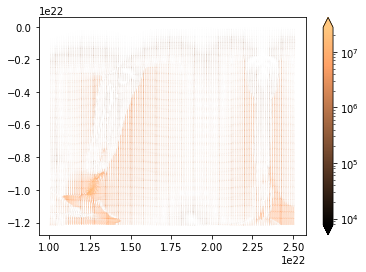

In [15]:
plt.clf
color = np.hypot(velXarrayZoom, velYarrayZoom)
#plt.tricontourf(posXarrayZoom, posYarrayZoom, densityArrayZoom, locator=ticker.LogLocator(), levels = 100) #good for irregular Z values
plt.quiver(posXarrayZoom, posYarrayZoom, velXarrayZoom, velYarrayZoom, color, norm=matplotlib.colors.LogNorm(),
           width=0.001, minlength = 0.001, headwidth=0.25, headlength=0.5, 
            cmap = plt.get_cmap('copper'))
plt.colorbar(extend='both', orientation='vertical')

## 2. Plotting with YT
YT is a very powerful tool for plotting. Much of what we need can be more easily done in YT, but it is more difficult to fine-tune the back end of the data we feed into it.

It is *much* easier and cleaner to plot basic plots:

In [3]:
import yt
filename = r"C:\Users\wongb\Documents\URS Data\m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_0076"
yt.toggle_interactivity() #Interactive plots?

Using matplotlib backend: Qt5Agg


yt : [INFO     ] 2021-08-04 23:12:49,863 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-08-04 23:12:49,864 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-08-04 23:12:49,865 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-08-04 23:12:49,866 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-08-04 23:12:49,867 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-08-04 23:12:51,672 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-08-04 23:12:51,673 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-08-04 23:12:51,674 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-08-04 23:12:51,674 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-08-04 23:12:51,676 Ma


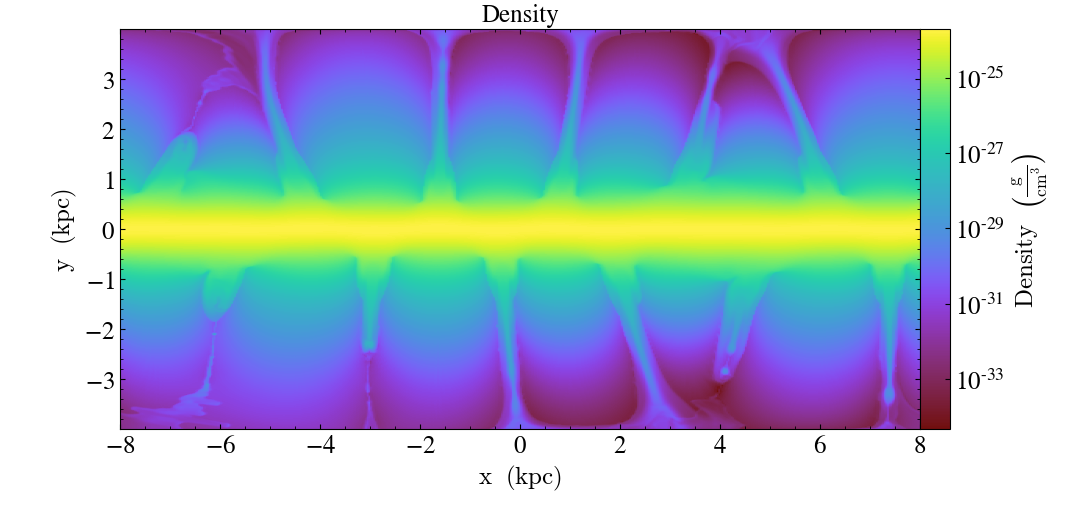

In [4]:
ds = yt.load(filename)
slc = yt.SlicePlot(ds, 'z', 'density')
slc.annotate_title("Density")

It is also easy to see all the included data:

In [6]:
for i in sorted(ds.field_list):
    print(i)
print('\n')
for i in sorted(ds.derived_field_list):
    print(i)

('flash', 'cray')
('flash', 'dens')
('flash', 'magx')
('flash', 'magy')
('flash', 'magz')
('flash', 'pres')
('flash', 'temp')
('flash', 'velx')
('flash', 'vely')
('flash', 'velz')


('flash', 'cell_volume')
('flash', 'cray')
('flash', 'dens')
('flash', 'dx')
('flash', 'dy')
('flash', 'dz')
('flash', 'magx')
('flash', 'magy')
('flash', 'magz')
('flash', 'path_element_x')
('flash', 'path_element_y')
('flash', 'path_element_z')
('flash', 'pres')
('flash', 'temp')
('flash', 'velx')
('flash', 'vely')
('flash', 'velz')
('flash', 'vertex_x')
('flash', 'vertex_y')
('flash', 'vertex_z')
('flash', 'x')
('flash', 'y')
('flash', 'z')
('gas', 'H_nuclei_density')
('gas', 'He_nuclei_density')
('gas', 'alfven_speed')
('gas', 'angular_momentum_magnitude')
('gas', 'angular_momentum_x')
('gas', 'angular_momentum_y')
('gas', 'angular_momentum_z')
('gas', 'averaged_density')
('gas', 'baroclinic_vorticity_magnitude')
('gas', 'baroclinic_vorticity_x')
('gas', 'baroclinic_vorticity_y')
('gas', 'baroclinic_vor

### 2.1 Zooming in YT
With some guesswork (on plot centres), it is also easy to zoom into a part of the plot:

yt : [INFO     ] 2021-07-07 11:56:36,280 xlim = 3.100000 5.100000
yt : [INFO     ] 2021-07-07 11:56:36,281 ylim = -3.850000 -1.850000
yt : [INFO     ] 2021-07-07 11:56:36,282 xlim = 9565600500983204413440.000000 15736955662907853504512.000000
yt : [INFO     ] 2021-07-07 11:56:36,283 ylim = -11879858686704949919744.000000 -5708503524780300828672.000000
yt : [INFO     ] 2021-07-07 11:56:36,284 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-07-07 11:56:37,523 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



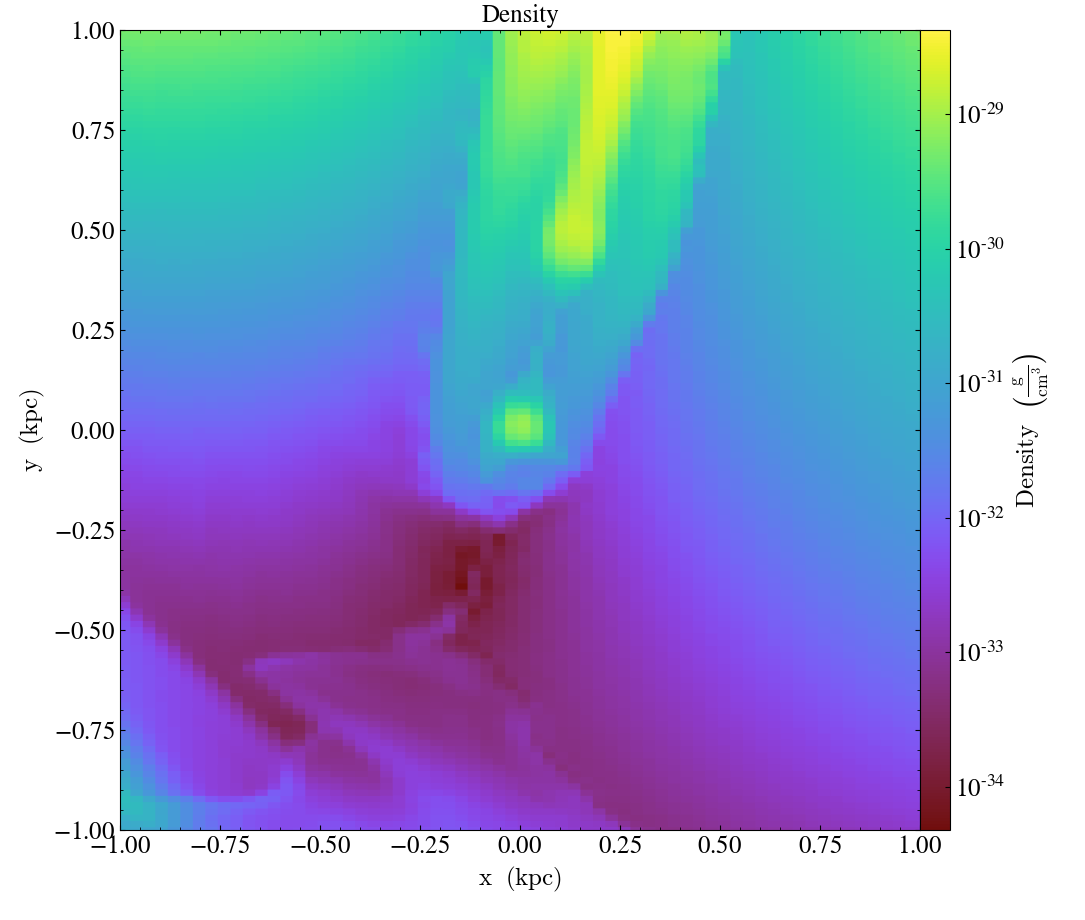

In [19]:
slc = yt.SlicePlot(ds, 'z', 'density', center=(4.1*kpc, -2.85*kpc, 0), width=(2*kpc, 2*kpc, 0)) #3D!!!
slc.set_width(2*kpc)
slc.annotate_title("Density")

Generally, this zooming strategy is janky and only works to navigate premade large plots. It is more difficult to, for example, select and examine the data only contained in the above box. The way to do this is to use YT Cut Regions.

yt : [INFO     ] 2021-07-07 11:56:43,738 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:43,739 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-07-07 11:56:43,740 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:43,741 ylim = -17602748466293062500352.000000 7077251533706935402496.000000
yt : [INFO     ] 2021-07-07 11:56:43,742 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-07-07 11:56:44,054 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



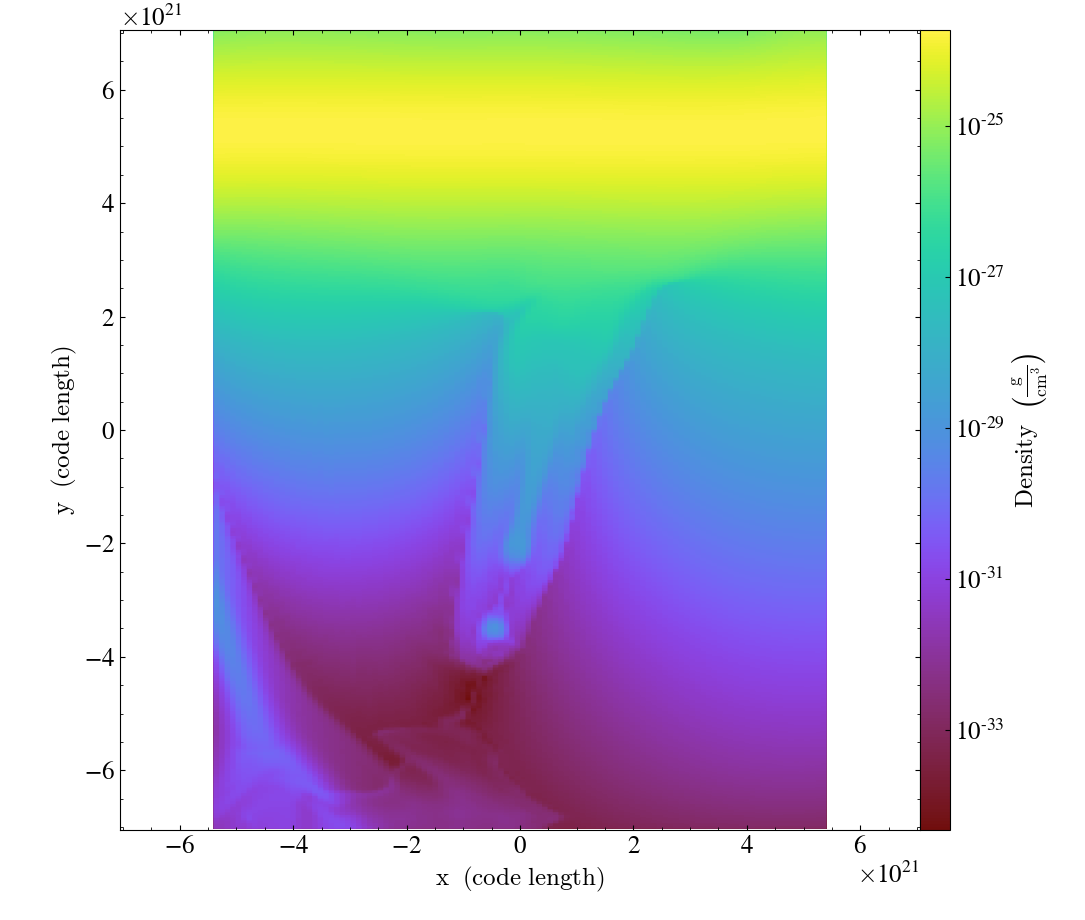

In [20]:
ad = ds.all_data()
conversion = 3.086e21 #kpc to cm
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 1.79040182984184e21}
dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))

Using a Cut Region allows us to manipulate the data that exists ONLY within these boundaries.

yt : [INFO     ] 2021-07-07 11:56:44,687 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-07-07 11:56:44,688 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:56:44,689 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:56:44,689 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:56:44,690 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:56:51,664 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:51,665 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:51,666 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:51,667 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:51,669 Maki


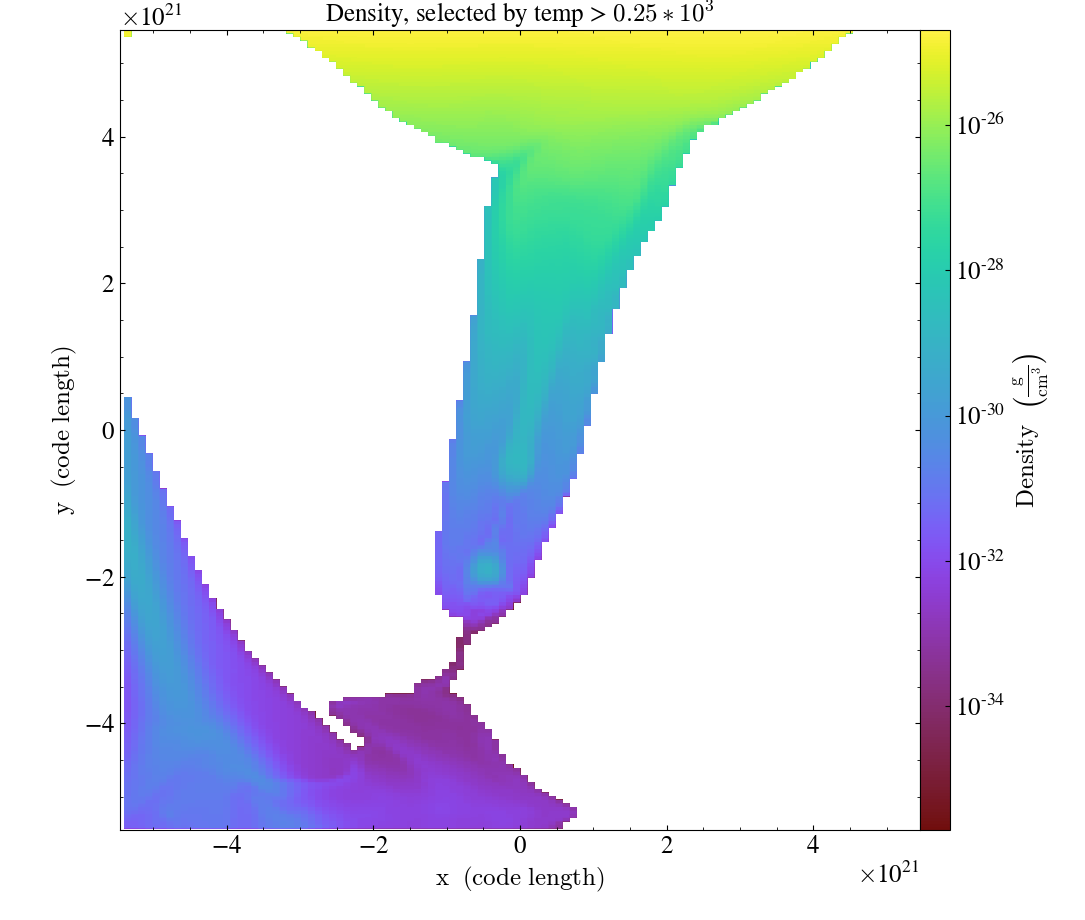

In [21]:
ds = yt.load(filename)
ad = ds.all_data()
# bounds = {'xmin': -0.3e+22, 'xmax': 0.22e+22, 'ymin': min(ad['y']).value,'ymax': 0}
conversion = 3.086e21 #kpc-->cm
# bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 0}
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': -1.40477660814861e21}

dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
dsSelect = dsSelect.cut_region("obj['temp'] > .25*10e3")
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                    center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
# slc.set_width(-min(ad['y']))

# dsSelect = ad.cut_region("obj['temp'] > .35*10e3")
# slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect)

# slc.set_ylim('y', min(ad['y']), 0)
slc.annotate_title("Density, selected by temp > $0.25*10^3$")

### 2.2 Velocity Vector Fields
YT has a built-in vector field plotting function.

yt : [INFO     ] 2021-07-07 11:56:52,433 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:52,434 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:52,435 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:52,435 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:52,437 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-07-07 11:56:52,683 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



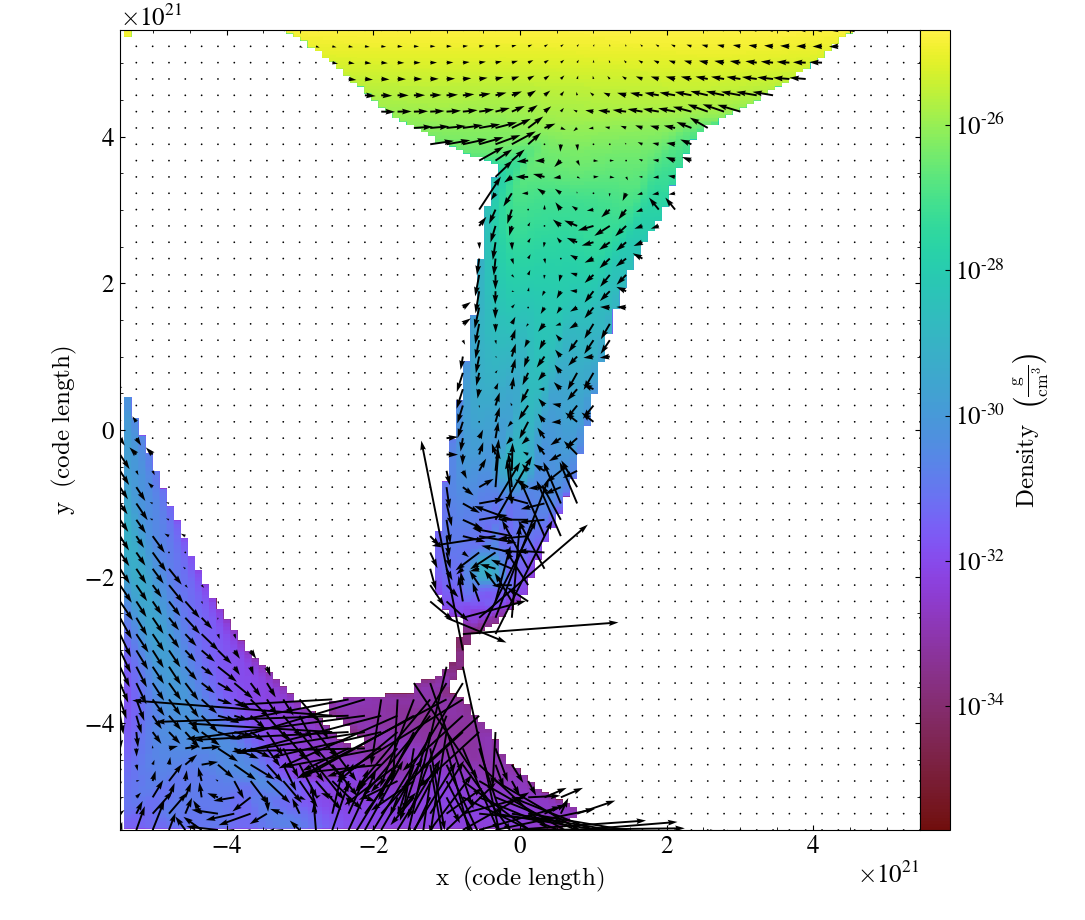

In [22]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_velocity(factor=16)

### 2.3 Streamlines
Streamlines allow us to more easily see trends in the vector fields:

yt : [INFO     ] 2021-07-07 11:56:53,353 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:53,354 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:53,355 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:53,356 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:53,358 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-07-07 11:56:53,593 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



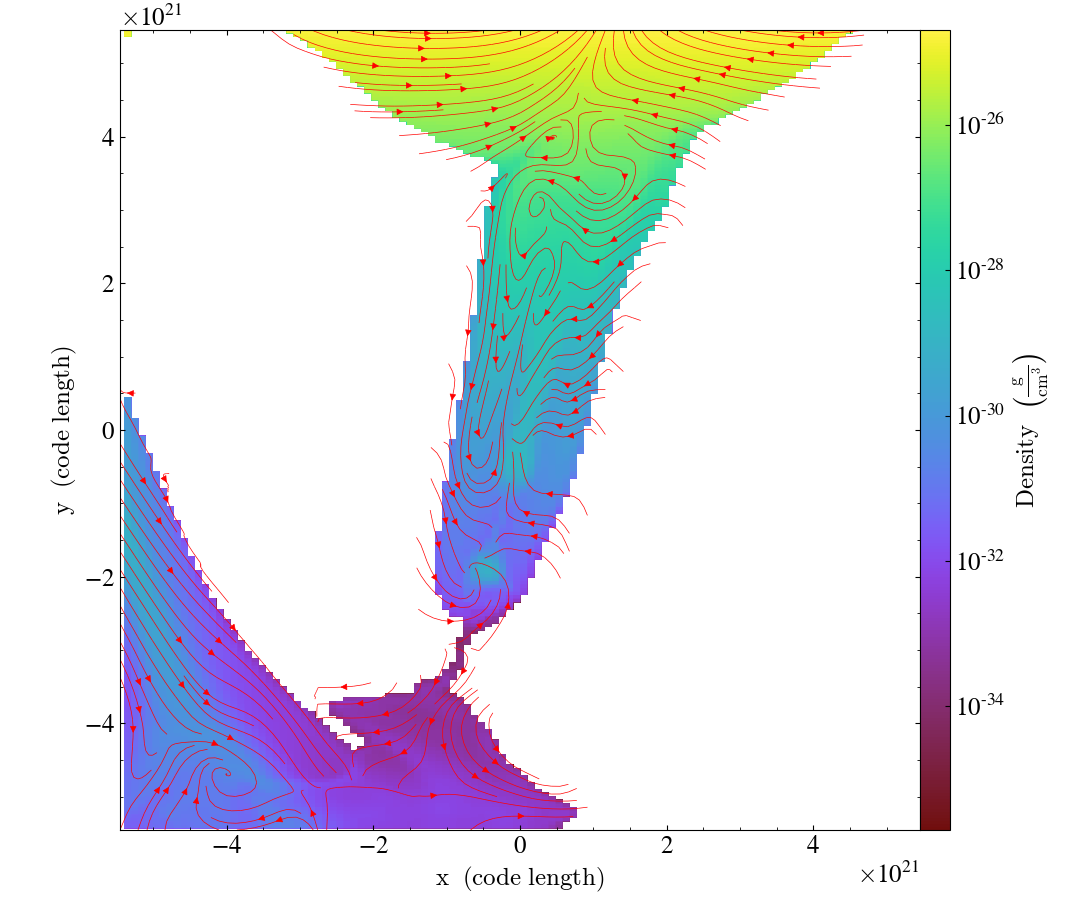

In [23]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('velocity_x','velocity_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

We can do the same for the magnetic field in the system

yt : [INFO     ] 2021-07-07 11:56:56,032 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:56,034 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:56,035 xlim = -11574499999999999344640.000000 37805499999999995412480.000000
yt : [INFO     ] 2021-07-07 11:56:56,036 ylim = -19200337685288287469568.000000 5479662314711710433280.000000
yt : [INFO     ] 2021-07-07 11:56:56,038 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2021-07-07 11:56:56,300 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



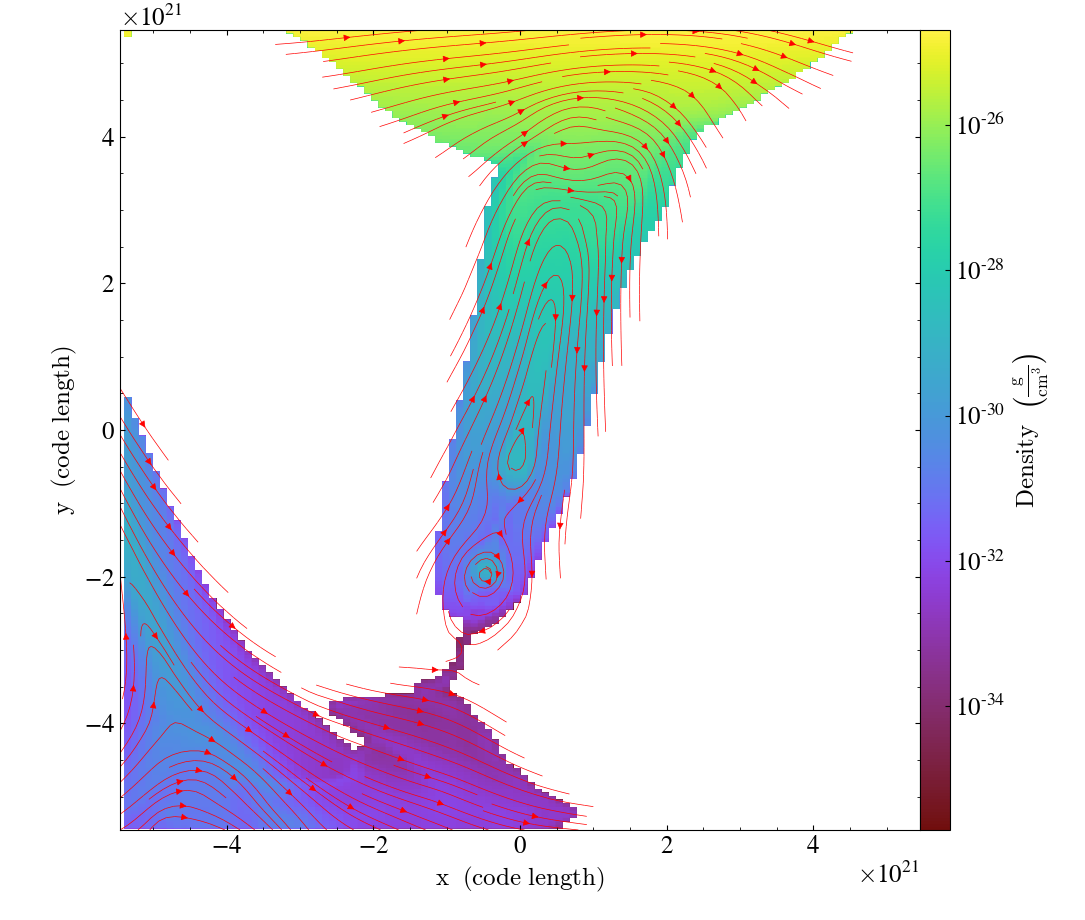

In [24]:
slc = yt.SlicePlot(ds, 'z', 'density', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))
slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

### 2.4 Making Gifs
We can make gifs of the entire simulation by plotting information from every timestamp. then stitching them into a gif using an online tool like https://ezgif.com/maker or a python package moviepy.

Set your directory to the one containing your simulation output files. Set the save directory to where you want to save the many output image plots. Specify the field you want to plot. Expect this code to take a bit of time to run, about a few minutes.

In [25]:
directory = "/Users/wongb/Documents/URS Data/m2_c1_16x8_64x64/More Plot Files/"
saveDirectory = "D:/URS_LargeData/SherryPlots"

field = 'density'

In [26]:
startTime = time.time()
for fileName in os.listdir(directory):
    #Find all simulation files. These files all start with parkerCRs,
    #e.g. parkerCRs_hdf5_plt_cnt_0076
    if(fileName.startswith("parkerCRs")):
        #Start
        print(fileName)
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        
        #SlicePlot
        slc = yt.SlicePlot(ds, 'z', field)
        # slc.annotate_velocity(factor=16)
        slc.annotate_title(timeStamp +" "+ field)
        plot = slc.plots[field]
        slc.set_zlim('density', 1e-33, 1e-24)
        # slc.set_zlim('temp', 1e2, 1e6)
        # slc.set_zlim(('gas', 'hrat'), 0.1e-27, 1e-28)
        # slc.annotate_streamlines('magnetic_field_x','magnetic_field_y',density=3,plot_args={'linewidth':0.5,'color':'r'}) 

        #Finish
        #https://stackabuse.com/creating-and-deleting-directories-with-python/
        #Create a new save folder if one does not exist already
        if (not path.exists(saveDirectory + "/" + field)):
            os.mkdir(saveDirectory + "/" + field)
            
        ### Enable the below line for the code to save anything;
        ### Disabled for the sake of jupyter
        # # slc.save(saveDirectory + "/" + field + "/" + timeStamp)
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Plotting done. Time elapsed (sec): " + str(time.time()-startTime))

parkerCRs_hdf5_plt_cnt_0000


yt : [INFO     ] 2021-07-07 11:56:58,458 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-07-07 11:56:58,459 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:56:58,459 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:56:58,460 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:56:58,462 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:00,358 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:00,359 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:00,361 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:00,362 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:00,364 Making a fixed resolu

parkerCRs_hdf5_plt_cnt_0001


yt : [INFO     ] 2021-07-07 11:57:01,607 Parameters: current_time              = 317264985381575.2
yt : [INFO     ] 2021-07-07 11:57:01,608 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:01,609 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:01,610 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:01,611 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:03,044 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:03,045 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:03,046 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:03,047 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:03,049 Making 

parkerCRs_hdf5_plt_cnt_0002


yt : [INFO     ] 2021-07-07 11:57:04,471 Parameters: current_time              = 631952027459833.6
yt : [INFO     ] 2021-07-07 11:57:04,472 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:04,473 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:04,474 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:04,475 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:06,004 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:06,005 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:06,006 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:06,007 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:06,008 Making 

parkerCRs_hdf5_plt_cnt_0003


yt : [INFO     ] 2021-07-07 11:57:07,572 Parameters: current_time              = 947866814238225.9
yt : [INFO     ] 2021-07-07 11:57:07,573 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:07,574 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:07,575 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:07,577 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:09,647 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:09,649 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:09,650 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:09,651 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:09,653 Making 

parkerCRs_hdf5_plt_cnt_0004


yt : [INFO     ] 2021-07-07 11:57:10,892 Parameters: current_time              = 1262476539434951.2
yt : [INFO     ] 2021-07-07 11:57:10,893 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:10,894 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:10,895 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:10,896 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:12,329 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:12,330 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:12,331 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:12,332 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:12,333 Making

parkerCRs_hdf5_plt_cnt_0005


yt : [INFO     ] 2021-07-07 11:57:13,365 Parameters: current_time              = 1578266342968121.8
yt : [INFO     ] 2021-07-07 11:57:13,366 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:13,367 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:13,368 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:13,369 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:15,423 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:15,425 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:15,426 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:15,427 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:15,428 Making

parkerCRs_hdf5_plt_cnt_0006


yt : [INFO     ] 2021-07-07 11:57:16,470 Parameters: current_time              = 1893515688749212.5
yt : [INFO     ] 2021-07-07 11:57:16,471 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:16,471 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:16,473 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:16,474 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:17,904 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:17,905 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:17,906 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:17,907 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:17,909 Making

parkerCRs_hdf5_plt_cnt_0007


yt : [INFO     ] 2021-07-07 11:57:18,959 Parameters: current_time              = 2209164029823500.8
yt : [INFO     ] 2021-07-07 11:57:18,960 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:18,961 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:18,962 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:18,963 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:20,420 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:20,422 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:20,424 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:20,425 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:20,426 Making

parkerCRs_hdf5_plt_cnt_0008


yt : [INFO     ] 2021-07-07 11:57:21,490 Parameters: current_time              = 2525184311118510.5
yt : [INFO     ] 2021-07-07 11:57:21,491 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:21,492 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:21,493 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:21,494 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:23,555 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:23,556 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:23,557 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:23,558 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:23,559 Making

parkerCRs_hdf5_plt_cnt_0009


yt : [INFO     ] 2021-07-07 11:57:24,601 Parameters: current_time              = 2840503028998597.0
yt : [INFO     ] 2021-07-07 11:57:24,602 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:24,603 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:24,605 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:24,606 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:26,088 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:26,089 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:26,090 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:26,091 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:26,093 Making

parkerCRs_hdf5_plt_cnt_0010


yt : [INFO     ] 2021-07-07 11:57:27,139 Parameters: current_time              = 3155862236714411.5
yt : [INFO     ] 2021-07-07 11:57:27,140 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:27,141 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:27,142 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:27,143 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:29,272 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:29,274 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:29,275 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:29,276 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:29,277 Making

parkerCRs_hdf5_plt_cnt_0011


yt : [INFO     ] 2021-07-07 11:57:30,321 Parameters: current_time              = 3471268345709315.0
yt : [INFO     ] 2021-07-07 11:57:30,323 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:30,323 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:30,324 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:30,325 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:31,726 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:31,728 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:31,729 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:31,730 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:31,731 Making

parkerCRs_hdf5_plt_cnt_0012


yt : [INFO     ] 2021-07-07 11:57:32,848 Parameters: current_time              = 3786142643652690.5
yt : [INFO     ] 2021-07-07 11:57:32,848 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:32,849 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:32,850 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:32,851 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:35,369 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:35,370 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:35,372 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:35,373 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:35,374 Making

parkerCRs_hdf5_plt_cnt_0013


yt : [INFO     ] 2021-07-07 11:57:36,702 Parameters: current_time              = 4102175170351167.0
yt : [INFO     ] 2021-07-07 11:57:36,704 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:36,704 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:36,706 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:36,707 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:38,451 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:38,452 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:38,453 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:38,454 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:38,456 Making

parkerCRs_hdf5_plt_cnt_0014


yt : [INFO     ] 2021-07-07 11:57:39,632 Parameters: current_time              = 4417602849178326.0
yt : [INFO     ] 2021-07-07 11:57:39,633 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:39,634 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:39,635 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:39,636 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:42,045 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:42,047 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:42,048 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:42,049 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:42,050 Making

parkerCRs_hdf5_plt_cnt_0015


yt : [INFO     ] 2021-07-07 11:57:43,275 Parameters: current_time              = 4733224019000497.0
yt : [INFO     ] 2021-07-07 11:57:43,276 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:43,276 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:43,277 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:43,278 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:44,927 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:44,928 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:44,929 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:44,930 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:44,932 Making

parkerCRs_hdf5_plt_cnt_0016


yt : [INFO     ] 2021-07-07 11:57:46,081 Parameters: current_time              = 5048681019761606.0
yt : [INFO     ] 2021-07-07 11:57:46,082 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:46,083 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:46,084 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:46,085 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:48,318 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:48,320 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:48,321 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:48,322 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:48,324 Making

parkerCRs_hdf5_plt_cnt_0017


yt : [INFO     ] 2021-07-07 11:57:49,396 Parameters: current_time              = 5363547157835992.0
yt : [INFO     ] 2021-07-07 11:57:49,397 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:49,397 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:49,399 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:49,400 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:50,796 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:50,797 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:50,798 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:50,799 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:50,801 Making

parkerCRs_hdf5_plt_cnt_0018


yt : [INFO     ] 2021-07-07 11:57:51,865 Parameters: current_time              = 5679631097980939.0
yt : [INFO     ] 2021-07-07 11:57:51,866 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:51,867 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:51,868 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:51,869 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:53,958 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:53,959 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:53,961 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:53,962 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:53,963 Making

parkerCRs_hdf5_plt_cnt_0019


yt : [INFO     ] 2021-07-07 11:57:55,005 Parameters: current_time              = 5994622447803141.0
yt : [INFO     ] 2021-07-07 11:57:55,006 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:55,007 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:55,008 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:55,009 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:56,443 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:56,444 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:56,445 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:56,446 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:56,447 Making

parkerCRs_hdf5_plt_cnt_0020


yt : [INFO     ] 2021-07-07 11:57:57,508 Parameters: current_time              = 6310249420236883.0
yt : [INFO     ] 2021-07-07 11:57:57,509 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:57:57,509 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:57,510 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:57:57,512 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:57:59,562 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:59,563 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:59,564 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:57:59,564 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:57:59,566 Making

parkerCRs_hdf5_plt_cnt_0021


yt : [INFO     ] 2021-07-07 11:58:00,630 Parameters: current_time              = 6626053871755637.0
yt : [INFO     ] 2021-07-07 11:58:00,631 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:00,631 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:00,632 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:00,633 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:02,079 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:02,081 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:02,082 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:02,083 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:02,084 Making

parkerCRs_hdf5_plt_cnt_0022


yt : [INFO     ] 2021-07-07 11:58:03,169 Parameters: current_time              = 6941478479349975.0
yt : [INFO     ] 2021-07-07 11:58:03,170 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:03,171 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:03,172 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:03,173 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:04,758 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:04,759 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:04,761 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:04,762 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:04,763 Making

parkerCRs_hdf5_plt_cnt_0023


yt : [INFO     ] 2021-07-07 11:58:05,934 Parameters: current_time              = 7256577386579009.0
yt : [INFO     ] 2021-07-07 11:58:05,936 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:05,937 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:05,938 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:05,939 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:08,138 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:08,139 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:08,140 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:08,141 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:08,143 Making

parkerCRs_hdf5_plt_cnt_0024


yt : [INFO     ] 2021-07-07 11:58:09,243 Parameters: current_time              = 7572229093200924.0
yt : [INFO     ] 2021-07-07 11:58:09,244 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:09,245 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:09,247 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:09,248 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:10,652 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:10,653 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:10,654 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:10,655 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:10,658 Making

parkerCRs_hdf5_plt_cnt_0025


yt : [INFO     ] 2021-07-07 11:58:11,688 Parameters: current_time              = 7887827062386465.0
yt : [INFO     ] 2021-07-07 11:58:11,688 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:11,689 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:11,690 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:11,691 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:13,863 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:13,865 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:13,866 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:13,867 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:13,868 Making

parkerCRs_hdf5_plt_cnt_0026


yt : [INFO     ] 2021-07-07 11:58:14,946 Parameters: current_time              = 8203329937430825.0
yt : [INFO     ] 2021-07-07 11:58:14,947 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:14,948 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:14,949 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:14,950 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:16,345 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:16,347 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:16,348 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:16,349 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:16,350 Making

parkerCRs_hdf5_plt_cnt_0027


yt : [INFO     ] 2021-07-07 11:58:17,385 Parameters: current_time              = 8518519234860240.0
yt : [INFO     ] 2021-07-07 11:58:17,386 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:17,387 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:17,388 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:17,389 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:19,464 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:19,465 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:19,466 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:19,467 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:19,468 Making

parkerCRs_hdf5_plt_cnt_0028


yt : [INFO     ] 2021-07-07 11:58:20,558 Parameters: current_time              = 8834271158348738.0
yt : [INFO     ] 2021-07-07 11:58:20,559 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:20,559 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:20,560 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:20,561 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:22,226 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:22,227 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:22,229 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:22,230 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:22,232 Making

parkerCRs_hdf5_plt_cnt_0029


yt : [INFO     ] 2021-07-07 11:58:23,469 Parameters: current_time              = 9149837787380592.0
yt : [INFO     ] 2021-07-07 11:58:23,470 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:23,471 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:23,472 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:23,473 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:25,534 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:25,535 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:25,536 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:25,537 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:25,538 Making

parkerCRs_hdf5_plt_cnt_0030


yt : [INFO     ] 2021-07-07 11:58:26,627 Parameters: current_time              = 9465119457627122.0
yt : [INFO     ] 2021-07-07 11:58:26,628 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:26,628 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:26,629 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:26,631 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:28,121 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:28,123 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:28,126 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:28,127 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:28,129 Making

parkerCRs_hdf5_plt_cnt_0031


yt : [INFO     ] 2021-07-07 11:58:29,221 Parameters: current_time              = 9780801276201566.0
yt : [INFO     ] 2021-07-07 11:58:29,222 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:29,223 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:29,224 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:29,225 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:31,365 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:31,366 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:31,367 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:31,368 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:31,369 Making

parkerCRs_hdf5_plt_cnt_0032


yt : [INFO     ] 2021-07-07 11:58:32,454 Parameters: current_time              = 1.0096336549334428e+16
yt : [INFO     ] 2021-07-07 11:58:32,455 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:32,455 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:32,456 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:32,457 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:33,947 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:33,949 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:33,951 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:33,951 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:33,953 Ma

parkerCRs_hdf5_plt_cnt_0033


yt : [INFO     ] 2021-07-07 11:58:35,238 Parameters: current_time              = 1.041153857414739e+16
yt : [INFO     ] 2021-07-07 11:58:35,239 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:35,240 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:35,242 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:35,243 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:37,652 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:37,653 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:37,654 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:37,655 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:37,657 Mak

parkerCRs_hdf5_plt_cnt_0034


yt : [INFO     ] 2021-07-07 11:58:38,884 Parameters: current_time              = 1.072729219785138e+16
yt : [INFO     ] 2021-07-07 11:58:38,885 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:38,886 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:38,887 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:38,888 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:40,571 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:40,572 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:40,574 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:40,575 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:40,577 Mak

parkerCRs_hdf5_plt_cnt_0035


yt : [INFO     ] 2021-07-07 11:58:41,684 Parameters: current_time              = 1.1042583708555828e+16
yt : [INFO     ] 2021-07-07 11:58:41,685 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:41,686 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:41,688 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:41,689 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:43,848 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:43,849 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:43,850 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:43,852 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:43,854 Ma

parkerCRs_hdf5_plt_cnt_0036


yt : [INFO     ] 2021-07-07 11:58:44,932 Parameters: current_time              = 1.1358074478540658e+16
yt : [INFO     ] 2021-07-07 11:58:44,933 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:44,934 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:44,934 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:44,935 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:46,407 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:46,408 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:46,409 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:46,410 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:46,412 Ma

parkerCRs_hdf5_plt_cnt_0037


yt : [INFO     ] 2021-07-07 11:58:47,487 Parameters: current_time              = 1.1673764951450424e+16
yt : [INFO     ] 2021-07-07 11:58:47,488 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:47,488 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:47,489 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:47,490 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:49,637 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:49,638 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:49,640 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:49,641 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:49,643 Ma

parkerCRs_hdf5_plt_cnt_0038


yt : [INFO     ] 2021-07-07 11:58:50,729 Parameters: current_time              = 1.1989161216667324e+16
yt : [INFO     ] 2021-07-07 11:58:50,730 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:50,730 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:50,731 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:50,732 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:52,210 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:52,211 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:52,212 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:52,213 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:52,215 Ma

parkerCRs_hdf5_plt_cnt_0039


yt : [INFO     ] 2021-07-07 11:58:53,283 Parameters: current_time              = 1.230452690487998e+16
yt : [INFO     ] 2021-07-07 11:58:53,284 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:53,285 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:53,286 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:53,287 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:55,470 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:55,472 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:55,473 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:55,474 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:55,475 Mak

parkerCRs_hdf5_plt_cnt_0040


yt : [INFO     ] 2021-07-07 11:58:56,561 Parameters: current_time              = 1.262007817563074e+16
yt : [INFO     ] 2021-07-07 11:58:56,562 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:56,563 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:56,564 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:56,565 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:58:58,023 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:58,024 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:58,025 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:58:58,026 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:58:58,028 Mak

parkerCRs_hdf5_plt_cnt_0041


yt : [INFO     ] 2021-07-07 11:58:59,087 Parameters: current_time              = 1.2935654000022814e+16
yt : [INFO     ] 2021-07-07 11:58:59,088 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:58:59,089 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:59,090 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:58:59,091 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:01,247 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:01,249 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:01,250 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:01,251 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:01,252 Ma

parkerCRs_hdf5_plt_cnt_0042


yt : [INFO     ] 2021-07-07 11:59:02,338 Parameters: current_time              = 1.32510613917787e+16
yt : [INFO     ] 2021-07-07 11:59:02,339 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:02,340 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:02,341 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:02,342 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:03,985 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:03,987 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:03,988 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:03,989 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:03,991 Maki

parkerCRs_hdf5_plt_cnt_0043


yt : [INFO     ] 2021-07-07 11:59:05,097 Parameters: current_time              = 1.3566684855142962e+16
yt : [INFO     ] 2021-07-07 11:59:05,099 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:05,099 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:05,100 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:05,101 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:06,774 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:06,776 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:06,777 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:06,777 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:06,779 Ma

parkerCRs_hdf5_plt_cnt_0044


yt : [INFO     ] 2021-07-07 11:59:08,013 Parameters: current_time              = 1.388230193251437e+16
yt : [INFO     ] 2021-07-07 11:59:08,014 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:08,015 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:08,016 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:08,017 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:10,255 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:10,256 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:10,258 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:10,259 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:10,261 Mak

parkerCRs_hdf5_plt_cnt_0045


yt : [INFO     ] 2021-07-07 11:59:11,324 Parameters: current_time              = 1.4197683183695348e+16
yt : [INFO     ] 2021-07-07 11:59:11,325 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:11,326 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:11,327 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:11,328 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:12,758 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:12,759 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:12,760 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:12,762 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:12,764 Ma

parkerCRs_hdf5_plt_cnt_0046


yt : [INFO     ] 2021-07-07 11:59:13,826 Parameters: current_time              = 1.4513165688654236e+16
yt : [INFO     ] 2021-07-07 11:59:13,827 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:13,828 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:13,830 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:13,831 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:16,061 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:16,063 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:16,064 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:16,065 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:16,066 Ma

parkerCRs_hdf5_plt_cnt_0047


yt : [INFO     ] 2021-07-07 11:59:17,163 Parameters: current_time              = 1.4828661517127606e+16
yt : [INFO     ] 2021-07-07 11:59:17,164 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:17,165 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:17,166 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:17,167 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:18,631 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:18,632 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:18,634 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:18,634 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:18,636 Ma

parkerCRs_hdf5_plt_cnt_0048


yt : [INFO     ] 2021-07-07 11:59:19,741 Parameters: current_time              = 1.5144109754540718e+16
yt : [INFO     ] 2021-07-07 11:59:19,742 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:19,743 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:19,744 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:19,745 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:21,893 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:21,894 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:21,895 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:21,896 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:21,898 Ma

parkerCRs_hdf5_plt_cnt_0049


yt : [INFO     ] 2021-07-07 11:59:22,963 Parameters: current_time              = 1.5459526028776102e+16
yt : [INFO     ] 2021-07-07 11:59:22,964 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:22,965 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:22,966 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:22,967 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:24,449 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:24,451 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:24,452 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:24,453 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:24,455 Ma

parkerCRs_hdf5_plt_cnt_0050


yt : [INFO     ] 2021-07-07 11:59:25,516 Parameters: current_time              = 1.5775101536425156e+16
yt : [INFO     ] 2021-07-07 11:59:25,518 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:25,519 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:25,520 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:25,522 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:27,676 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:27,677 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:27,678 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:27,679 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:27,680 Ma

parkerCRs_hdf5_plt_cnt_0051


yt : [INFO     ] 2021-07-07 11:59:28,765 Parameters: current_time              = 1.6090694763025638e+16
yt : [INFO     ] 2021-07-07 11:59:28,766 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:28,767 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:28,768 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:28,770 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:30,233 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:30,234 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:30,235 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:30,236 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:30,238 Ma

parkerCRs_hdf5_plt_cnt_0052


yt : [INFO     ] 2021-07-07 11:59:31,326 Parameters: current_time              = 1.6406198712477252e+16
yt : [INFO     ] 2021-07-07 11:59:31,327 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:31,328 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:31,329 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:31,330 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:33,446 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:33,447 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:33,449 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:33,450 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:33,451 Ma

parkerCRs_hdf5_plt_cnt_0053


yt : [INFO     ] 2021-07-07 11:59:34,527 Parameters: current_time              = 1.6721510641700554e+16
yt : [INFO     ] 2021-07-07 11:59:34,528 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:34,528 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:34,530 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:34,531 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:36,017 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:36,018 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:36,019 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:36,020 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:36,021 Ma

parkerCRs_hdf5_plt_cnt_0054


yt : [INFO     ] 2021-07-07 11:59:37,086 Parameters: current_time              = 1.7037104511599786e+16
yt : [INFO     ] 2021-07-07 11:59:37,087 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:37,088 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:37,089 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:37,090 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:39,219 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:39,220 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:39,221 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:39,222 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:39,224 Ma

parkerCRs_hdf5_plt_cnt_0055


yt : [INFO     ] 2021-07-07 11:59:40,301 Parameters: current_time              = 1.7352634873991754e+16
yt : [INFO     ] 2021-07-07 11:59:40,303 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:40,303 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:40,304 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:40,305 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:41,778 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:41,780 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:41,781 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:41,782 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:41,783 Ma

parkerCRs_hdf5_plt_cnt_0056


yt : [INFO     ] 2021-07-07 11:59:42,856 Parameters: current_time              = 1.7668059870350726e+16
yt : [INFO     ] 2021-07-07 11:59:42,857 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:42,858 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:42,859 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:42,860 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:44,359 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:44,360 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:44,362 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:44,363 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:44,364 Ma

parkerCRs_hdf5_plt_cnt_0057


yt : [INFO     ] 2021-07-07 11:59:46,152 Parameters: current_time              = 1.798351814140949e+16
yt : [INFO     ] 2021-07-07 11:59:46,152 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:46,153 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:46,155 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:46,156 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:47,636 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:47,637 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:47,638 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:47,639 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:47,641 Mak

parkerCRs_hdf5_plt_cnt_0058


yt : [INFO     ] 2021-07-07 11:59:48,718 Parameters: current_time              = 1.829901177738466e+16
yt : [INFO     ] 2021-07-07 11:59:48,719 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:48,719 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:48,720 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:48,721 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:50,194 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:50,195 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:50,196 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:50,197 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:50,198 Mak

parkerCRs_hdf5_plt_cnt_0059


yt : [INFO     ] 2021-07-07 11:59:51,285 Parameters: current_time              = 1.8614546000181764e+16
yt : [INFO     ] 2021-07-07 11:59:51,286 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:51,286 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:51,288 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:51,289 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:53,488 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:53,489 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:53,490 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:53,491 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:53,493 Ma

parkerCRs_hdf5_plt_cnt_0060


yt : [INFO     ] 2021-07-07 11:59:54,567 Parameters: current_time              = 1.8930031846135068e+16
yt : [INFO     ] 2021-07-07 11:59:54,568 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:54,569 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:54,570 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:54,571 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:56,031 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:56,032 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:56,034 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:56,036 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:56,038 Ma

parkerCRs_hdf5_plt_cnt_0061


yt : [INFO     ] 2021-07-07 11:59:57,103 Parameters: current_time              = 1.9245607264936308e+16
yt : [INFO     ] 2021-07-07 11:59:57,104 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 11:59:57,105 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:57,106 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 11:59:57,107 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 11:59:59,354 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:59,355 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:59,356 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 11:59:59,358 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 11:59:59,360 Ma

parkerCRs_hdf5_plt_cnt_0062


yt : [INFO     ] 2021-07-07 12:00:00,457 Parameters: current_time              = 1.9561049103394252e+16
yt : [INFO     ] 2021-07-07 12:00:00,458 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:00,458 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:00,459 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:00,460 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:01,923 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:01,924 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:01,925 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:01,926 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:01,928 Ma

parkerCRs_hdf5_plt_cnt_0063


yt : [INFO     ] 2021-07-07 12:00:03,010 Parameters: current_time              = 1.987655432844015e+16
yt : [INFO     ] 2021-07-07 12:00:03,011 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:03,012 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:03,014 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:03,015 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:05,149 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:05,151 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:05,152 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:05,153 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:05,155 Mak

parkerCRs_hdf5_plt_cnt_0064


yt : [INFO     ] 2021-07-07 12:00:06,249 Parameters: current_time              = 2.0192009221179732e+16
yt : [INFO     ] 2021-07-07 12:00:06,250 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:06,251 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:06,252 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:06,253 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:07,708 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:07,709 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:07,711 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:07,712 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:07,714 Ma

parkerCRs_hdf5_plt_cnt_0065


yt : [INFO     ] 2021-07-07 12:00:08,785 Parameters: current_time              = 2.050759163780496e+16
yt : [INFO     ] 2021-07-07 12:00:08,787 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:08,787 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:08,789 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:08,790 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:10,986 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:10,988 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:10,989 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:10,990 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:10,992 Mak

parkerCRs_hdf5_plt_cnt_0066


yt : [INFO     ] 2021-07-07 12:00:12,072 Parameters: current_time              = 2.082308198763476e+16
yt : [INFO     ] 2021-07-07 12:00:12,073 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:12,073 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:12,074 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:12,075 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:13,536 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:13,538 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:13,539 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:13,540 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:13,541 Mak

parkerCRs_hdf5_plt_cnt_0067


yt : [INFO     ] 2021-07-07 12:00:14,623 Parameters: current_time              = 2.113850371894025e+16
yt : [INFO     ] 2021-07-07 12:00:14,624 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:14,624 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:14,625 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:14,627 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:16,794 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:16,795 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:16,797 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:16,798 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:16,800 Mak

parkerCRs_hdf5_plt_cnt_0068


yt : [INFO     ] 2021-07-07 12:00:18,046 Parameters: current_time              = 2.145404877140186e+16
yt : [INFO     ] 2021-07-07 12:00:18,047 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:18,049 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:18,050 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:18,051 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:19,812 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:19,813 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:19,814 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:19,815 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:19,816 Mak

parkerCRs_hdf5_plt_cnt_0069


yt : [INFO     ] 2021-07-07 12:00:21,022 Parameters: current_time              = 2.176956526081605e+16
yt : [INFO     ] 2021-07-07 12:00:21,024 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:21,025 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:21,026 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:21,028 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:22,762 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:22,763 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:22,764 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:22,765 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:22,767 Mak

parkerCRs_hdf5_plt_cnt_0070


yt : [INFO     ] 2021-07-07 12:00:23,906 Parameters: current_time              = 2.208500251509022e+16
yt : [INFO     ] 2021-07-07 12:00:23,907 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:23,907 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:23,909 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:23,910 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:26,275 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:26,276 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:26,277 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:26,278 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:26,280 Mak

parkerCRs_hdf5_plt_cnt_0071


yt : [INFO     ] 2021-07-07 12:00:27,360 Parameters: current_time              = 2.240052005791999e+16
yt : [INFO     ] 2021-07-07 12:00:27,361 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:27,361 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:27,362 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:27,363 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:28,840 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:28,842 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:28,843 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:28,844 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:28,845 Mak

parkerCRs_hdf5_plt_cnt_0072


yt : [INFO     ] 2021-07-07 12:00:29,915 Parameters: current_time              = 2.2716071082079296e+16
yt : [INFO     ] 2021-07-07 12:00:29,916 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:29,916 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:29,917 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:29,918 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:32,180 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:32,182 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:32,183 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:32,184 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:32,185 Ma

parkerCRs_hdf5_plt_cnt_0073


yt : [INFO     ] 2021-07-07 12:00:33,252 Parameters: current_time              = 2.3031568829813564e+16
yt : [INFO     ] 2021-07-07 12:00:33,253 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:33,254 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:33,255 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:33,256 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:34,707 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:34,708 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:34,710 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:34,711 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:34,713 Ma

parkerCRs_hdf5_plt_cnt_0074


yt : [INFO     ] 2021-07-07 12:00:35,783 Parameters: current_time              = 2.3347031862569668e+16
yt : [INFO     ] 2021-07-07 12:00:35,784 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:35,785 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:35,786 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:35,787 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:37,924 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:37,925 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:37,926 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:37,927 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:37,929 Ma

parkerCRs_hdf5_plt_cnt_0075


yt : [INFO     ] 2021-07-07 12:00:38,993 Parameters: current_time              = 2.3662546553652868e+16
yt : [INFO     ] 2021-07-07 12:00:38,994 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:38,995 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:38,996 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:38,997 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:40,451 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:40,453 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:40,454 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:40,455 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:40,457 Ma

parkerCRs_hdf5_plt_cnt_0076


yt : [INFO     ] 2021-07-07 12:00:41,514 Parameters: current_time              = 2.3978042272661256e+16
yt : [INFO     ] 2021-07-07 12:00:41,515 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:41,515 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:41,516 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:41,518 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:43,651 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:43,652 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:43,653 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:43,654 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:43,655 Ma

parkerCRs_hdf5_plt_cnt_0077


yt : [INFO     ] 2021-07-07 12:00:44,723 Parameters: current_time              = 2.429352167714028e+16
yt : [INFO     ] 2021-07-07 12:00:44,724 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:44,725 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:44,725 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:44,727 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:46,215 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:46,216 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:46,218 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:46,219 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:46,220 Mak

parkerCRs_hdf5_plt_cnt_0078


yt : [INFO     ] 2021-07-07 12:00:47,293 Parameters: current_time              = 2.4609046503715988e+16
yt : [INFO     ] 2021-07-07 12:00:47,294 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:47,294 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:47,296 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:47,297 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:49,456 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:49,458 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:49,459 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:49,460 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:49,461 Ma

parkerCRs_hdf5_plt_cnt_0079


yt : [INFO     ] 2021-07-07 12:00:50,552 Parameters: current_time              = 2.4924503651864696e+16
yt : [INFO     ] 2021-07-07 12:00:50,553 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:50,554 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:50,555 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:50,556 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:52,037 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:52,038 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:52,040 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:52,041 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:52,043 Ma

parkerCRs_hdf5_plt_cnt_0080


yt : [INFO     ] 2021-07-07 12:00:53,108 Parameters: current_time              = 2.52400226701763e+16
yt : [INFO     ] 2021-07-07 12:00:53,109 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:53,110 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:53,111 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:53,112 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:55,244 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:55,245 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:55,246 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:55,247 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:55,248 Maki

parkerCRs_hdf5_plt_cnt_0081


yt : [INFO     ] 2021-07-07 12:00:56,312 Parameters: current_time              = 2.5555516224875828e+16
yt : [INFO     ] 2021-07-07 12:00:56,313 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:56,314 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:56,315 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:56,316 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:00:57,777 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:57,778 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:57,779 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:00:57,780 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:00:57,782 Ma

parkerCRs_hdf5_plt_cnt_0082


yt : [INFO     ] 2021-07-07 12:00:58,833 Parameters: current_time              = 2.587100402815486e+16
yt : [INFO     ] 2021-07-07 12:00:58,834 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:00:58,835 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:58,836 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:00:58,837 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:01,003 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:01,004 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:01,006 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:01,007 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:01,008 Mak

parkerCRs_hdf5_plt_cnt_0083


yt : [INFO     ] 2021-07-07 12:01:02,091 Parameters: current_time              = 2.6186509654752772e+16
yt : [INFO     ] 2021-07-07 12:01:02,092 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:02,093 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:02,094 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:02,095 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:03,550 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:03,552 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:03,553 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:03,554 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:03,556 Ma

parkerCRs_hdf5_plt_cnt_0084


yt : [INFO     ] 2021-07-07 12:01:04,624 Parameters: current_time              = 2.65020022249852e+16
yt : [INFO     ] 2021-07-07 12:01:04,625 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:04,625 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:04,626 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:04,627 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:06,758 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:06,760 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:06,761 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:06,761 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:06,763 Maki

parkerCRs_hdf5_plt_cnt_0085


yt : [INFO     ] 2021-07-07 12:01:07,840 Parameters: current_time              = 2.681752019936819e+16
yt : [INFO     ] 2021-07-07 12:01:07,842 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:07,842 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:07,843 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:07,845 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:09,385 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:09,386 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:09,387 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:09,388 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:09,390 Mak

parkerCRs_hdf5_plt_cnt_0086


yt : [INFO     ] 2021-07-07 12:01:10,545 Parameters: current_time              = 2.7133001171239772e+16
yt : [INFO     ] 2021-07-07 12:01:10,546 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:10,547 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:10,548 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:10,549 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:12,014 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:12,016 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:12,017 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:12,018 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:12,020 Ma

parkerCRs_hdf5_plt_cnt_0087


yt : [INFO     ] 2021-07-07 12:01:13,819 Parameters: current_time              = 2.744850133288634e+16
yt : [INFO     ] 2021-07-07 12:01:13,820 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:13,821 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:13,822 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:13,823 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:15,285 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:15,286 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:15,287 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:15,288 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:15,290 Mak

parkerCRs_hdf5_plt_cnt_0088


yt : [INFO     ] 2021-07-07 12:01:16,367 Parameters: current_time              = 2.776401075797512e+16
yt : [INFO     ] 2021-07-07 12:01:16,368 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:16,369 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:16,370 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:16,372 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:17,846 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:17,847 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:17,848 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:17,850 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:17,851 Mak

parkerCRs_hdf5_plt_cnt_0089


yt : [INFO     ] 2021-07-07 12:01:18,911 Parameters: current_time              = 2.8079549680651308e+16
yt : [INFO     ] 2021-07-07 12:01:18,912 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:18,912 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:18,914 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:18,915 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:21,178 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:21,179 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:21,181 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:21,182 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:21,184 Ma

parkerCRs_hdf5_plt_cnt_0090


yt : [INFO     ] 2021-07-07 12:01:22,384 Parameters: current_time              = 2.8395080790695696e+16
yt : [INFO     ] 2021-07-07 12:01:22,386 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:22,387 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:22,388 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:22,389 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:24,003 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:24,004 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:24,005 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:24,006 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:24,008 Ma

parkerCRs_hdf5_plt_cnt_0091


yt : [INFO     ] 2021-07-07 12:01:25,158 Parameters: current_time              = 2.8710585387788036e+16
yt : [INFO     ] 2021-07-07 12:01:25,160 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:25,161 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:25,163 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:25,164 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:27,616 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:27,617 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:27,619 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:27,623 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:27,624 Ma

parkerCRs_hdf5_plt_cnt_0092


yt : [INFO     ] 2021-07-07 12:01:28,767 Parameters: current_time              = 2.902613831277867e+16
yt : [INFO     ] 2021-07-07 12:01:28,768 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:28,769 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:28,771 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:28,772 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:30,531 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:30,533 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:30,534 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:30,536 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:30,537 Mak

parkerCRs_hdf5_plt_cnt_0093


yt : [INFO     ] 2021-07-07 12:01:31,771 Parameters: current_time              = 2.9341507540739804e+16
yt : [INFO     ] 2021-07-07 12:01:31,772 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:31,773 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:31,774 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:31,776 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:33,921 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:33,924 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:33,925 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:33,926 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:33,927 Ma

parkerCRs_hdf5_plt_cnt_0094


yt : [INFO     ] 2021-07-07 12:01:34,993 Parameters: current_time              = 2.9657121436498424e+16
yt : [INFO     ] 2021-07-07 12:01:34,994 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:34,995 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:34,996 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:34,998 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:36,459 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:36,460 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:36,461 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:36,462 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:36,463 Ma

parkerCRs_hdf5_plt_cnt_0095


yt : [INFO     ] 2021-07-07 12:01:37,528 Parameters: current_time              = 2.9972589552576828e+16
yt : [INFO     ] 2021-07-07 12:01:37,529 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:37,530 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:37,531 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:37,532 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:39,693 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:39,694 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:39,695 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:39,696 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:39,698 Ma

parkerCRs_hdf5_plt_cnt_0096


yt : [INFO     ] 2021-07-07 12:01:40,764 Parameters: current_time              = 3.028800851564307e+16
yt : [INFO     ] 2021-07-07 12:01:40,765 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:40,766 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:40,766 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:40,767 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:42,216 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:42,217 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:42,218 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:42,219 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:42,221 Mak

parkerCRs_hdf5_plt_cnt_0097


yt : [INFO     ] 2021-07-07 12:01:43,294 Parameters: current_time              = 3.0603550115986356e+16
yt : [INFO     ] 2021-07-07 12:01:43,295 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:43,296 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:43,298 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:43,299 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:45,481 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:45,482 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:45,484 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:45,485 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:45,486 Ma

parkerCRs_hdf5_plt_cnt_0098


yt : [INFO     ] 2021-07-07 12:01:46,553 Parameters: current_time              = 3.0919012328293236e+16
yt : [INFO     ] 2021-07-07 12:01:46,554 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:46,555 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:46,556 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:46,557 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:48,020 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:48,021 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:48,023 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:48,025 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:48,027 Ma

parkerCRs_hdf5_plt_cnt_0099


yt : [INFO     ] 2021-07-07 12:01:49,109 Parameters: current_time              = 3.1234522623824548e+16
yt : [INFO     ] 2021-07-07 12:01:49,110 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:49,111 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:49,113 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:49,114 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:50,616 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:50,617 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:50,619 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:50,620 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:50,622 Ma

parkerCRs_hdf5_plt_cnt_0100


yt : [INFO     ] 2021-07-07 12:01:51,692 Parameters: current_time              = 3.155000253149007e+16
yt : [INFO     ] 2021-07-07 12:01:51,693 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:51,694 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:51,695 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:51,696 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:53,899 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:53,900 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:53,901 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:53,903 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:53,904 Mak

parkerCRs_hdf5_plt_cnt_0101


yt : [INFO     ] 2021-07-07 12:01:54,991 Parameters: current_time              = 3.1865509190872964e+16
yt : [INFO     ] 2021-07-07 12:01:54,992 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:54,993 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:54,994 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:54,995 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:56,492 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:56,494 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:56,495 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:56,496 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:56,497 Ma

parkerCRs_hdf5_plt_cnt_0102


yt : [INFO     ] 2021-07-07 12:01:57,590 Parameters: current_time              = 3.2181004650868388e+16
yt : [INFO     ] 2021-07-07 12:01:57,591 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:01:57,592 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:57,594 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:01:57,595 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:01:59,832 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:59,834 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:59,835 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:01:59,836 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:01:59,837 Ma

parkerCRs_hdf5_plt_cnt_0103


yt : [INFO     ] 2021-07-07 12:02:00,981 Parameters: current_time              = 3.2496503417513716e+16
yt : [INFO     ] 2021-07-07 12:02:00,983 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:00,983 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:00,985 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:00,986 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:02,456 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:02,457 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:02,458 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:02,459 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:02,461 Ma

parkerCRs_hdf5_plt_cnt_0104


yt : [INFO     ] 2021-07-07 12:02:03,630 Parameters: current_time              = 3.2812001372869292e+16
yt : [INFO     ] 2021-07-07 12:02:03,631 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:03,632 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:03,633 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:03,635 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:05,764 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:05,765 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:05,766 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:05,768 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:05,769 Ma

parkerCRs_hdf5_plt_cnt_0105


yt : [INFO     ] 2021-07-07 12:02:06,845 Parameters: current_time              = 3.312750174353088e+16
yt : [INFO     ] 2021-07-07 12:02:06,845 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:06,846 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:06,847 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:06,848 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:08,309 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:08,311 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:08,313 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:08,314 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:08,315 Mak

parkerCRs_hdf5_plt_cnt_0106


yt : [INFO     ] 2021-07-07 12:02:09,441 Parameters: current_time              = 3.3443019624258988e+16
yt : [INFO     ] 2021-07-07 12:02:09,442 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:09,443 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:09,444 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:09,446 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:11,630 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:11,631 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:11,632 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:11,633 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:11,635 Ma

parkerCRs_hdf5_plt_cnt_0107


yt : [INFO     ] 2021-07-07 12:02:12,698 Parameters: current_time              = 3.3758507044723044e+16
yt : [INFO     ] 2021-07-07 12:02:12,700 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:12,701 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:12,702 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:12,703 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:14,173 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:14,174 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:14,175 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:14,176 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:14,178 Ma

parkerCRs_hdf5_plt_cnt_0108


yt : [INFO     ] 2021-07-07 12:02:15,240 Parameters: current_time              = 3.407400838726097e+16
yt : [INFO     ] 2021-07-07 12:02:15,241 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:15,242 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:15,243 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:15,244 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:17,413 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:17,415 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:17,416 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:17,417 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:17,419 Mak

parkerCRs_hdf5_plt_cnt_0109


yt : [INFO     ] 2021-07-07 12:02:18,464 Parameters: current_time              = 3.4389505331367276e+16
yt : [INFO     ] 2021-07-07 12:02:18,465 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:18,465 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:18,466 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:18,467 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:19,923 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:19,924 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:19,927 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:19,928 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:19,930 Ma

parkerCRs_hdf5_plt_cnt_0110


yt : [INFO     ] 2021-07-07 12:02:21,017 Parameters: current_time              = 3.4705004827524628e+16
yt : [INFO     ] 2021-07-07 12:02:21,018 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:21,019 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:21,020 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:21,022 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:23,183 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:23,184 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:23,185 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:23,186 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:23,187 Ma

parkerCRs_hdf5_plt_cnt_0111


yt : [INFO     ] 2021-07-07 12:02:24,255 Parameters: current_time              = 3.502050179106553e+16
yt : [INFO     ] 2021-07-07 12:02:24,256 Parameters: domain_dimensions         = [512 512   1]
yt : [INFO     ] 2021-07-07 12:02:24,257 Parameters: domain_left_edge          = [-2.469e+22 -1.234e+22 -6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:24,258 Parameters: domain_right_edge         = [2.469e+22 1.234e+22 6.171e+21]
yt : [INFO     ] 2021-07-07 12:02:24,259 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-07-07 12:02:25,734 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:25,735 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:25,736 xlim = -24689999999999999475712.000000 24689999999999999475712.000000
yt : [INFO     ] 2021-07-07 12:02:25,737 ylim = -12339999999999998951424.000000 12339999999999998951424.000000
yt : [INFO     ] 2021-07-07 12:02:25,739 Mak


~~~~~~~~~~~~~~~~~~~~~~~~~~~
Plotting done. Time elapsed (sec): 334.2293803691864


If you only want a particular range of timesteps, use the below code:

In [27]:
for t in range(65, 85):
    filenames.append("/Users/wongb/Documents/URS Data/m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_00"
                     +str(t)) #t is a 2 digit number
    ds = yt.load("/Users/wongb/Documents/URS Data/m2_c1_16x8_64x64/More Plot Files/parkerCRs_hdf5_plt_cnt_00"
                     +str(t))
    timeStamp = t
    
    #all the plotting stuff is the same here

NameError: name 'filenames' is not defined

If you want to zoom while doing that:

In [ ]:

ylim = -1.79040182984184e21 #in cm
bounds = {'xmin': 2.1*pow(10, 22), 'xmax': 2.5*pow(10, 22), 'ymin': float(min(ad['y']).value),'ymax': ylim}
for t in range(65, 85):
    ds = yt.load(directory+fileName)
    ad = ds.all_data()
        
    #cut desired region
    dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
    dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
    
    slc = yt.SlicePlot(ds, 'z', field, data_source=dsSelect, 
                       #adjust center
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
    slc.annotate_title(timeStamp +" "+ field)
    
    #truncate plot
    slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))


The below code will take the images in your chosen save directory, create a gif, and save it to the same directory. You can trim the beginning/end of the gif by deleting unwanted frames from the save directory.

In [ ]:
#https://www.tutorialexample.com/python-create-gif-with-images-using-moviepy-a-complete-guide-python-tutorial/

# images = []
# for fileName in os.listdir(saveDirectory + '/' + field): #set in initial parameters
#     images.append(saveDirectory + '/' + field + '/' + fileName)
# print(images)
# clip = ImageSequenceClip(images, fps=5)
# clip.write_gif(saveDirectory + '/' + field + '.gif') #saves in outside folder
# clip.close()
#DANGER!!! The line below removes the directory.
# # shutil.rmtree(saveDirectory + '/' + field) #delete images to save space


Combining this with magnetic streamlines, we get: 
<img src="densityFIXED_64x64.gif">

### 2.5 Total Mass
Using a similar loop as above to iterate through all simulations, we can easily keep track of the total mass contained in each frame of the simulation.

This code similarly takes a few minutes to run.

In [ ]:
startTime = time.time()

# two axes to plot later
timeStamps = []
mass = []

#iterate through simulation files
for fileName in os.listdir(directory):
    if(fileName.startswith("parkerCRs")): #find all simulation files
        #Start
        print(fileName)
        #use the timestamp in the file name
        #e.g. parkerCRs_hdf5_plt_cnt_0076 --> 0076
        timeStamp = fileName[len(fileName)-4: len(fileName)]
        ds = yt.load(directory+fileName)
        ad = ds.all_data()
        timeStamps.append(int(timeStamp))
        mass.append(sum(ad[('gas', 'cell_mass')]))
beepy.beep(4)
print()
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Mass calc done. Time elapsed (sec): " + str(time.time()-startTime))

plt.clf()
# upperTick = round( np.amax(mass) )
# bottomTick = round( np.amin(mass) )
# log = np.logspace(bottomTick, upperTick, 8)
# plt.plot(timeStamps, np.log10(mass))
plt.plot(timeStamps, mass)

Doing this results in a plot that looks like this:
<img src="totalMassLogScale_m2_c1_16x8_64x64.png" width="600">

The simulation is very stable for a while, loses ~10e38g, then gains mass quickly at the end of the simulation. This may or may not

#### Mass flux

In [ ]:
flux = ad['density']*ad['vely']
plt.tricontourf(ad['x'], ad['y'], flux, norm=matplotlib.colors.SymLogNorm(linthresh=0.01))
plt.title("0076: flux using SymLogNorm")
plt.colorbar()

#### Clumps?

In [ ]:
ad = ds.all_data()
conversion = 3.086e21 #kpc to cm
bounds = {'xmin': 2.5*conversion, 'xmax': 6*conversion, 'ymin': float(min(ad['y']).value),'ymax': 1.79040182984184e21}
dsSelect = ad.include_inside('x', bounds['xmin'], bounds['xmax'])
dsSelect = dsSelect.include_inside('y', bounds['ymin'], bounds['ymax'])
slc = yt.SlicePlot(ds, 'z', 'temp', data_source=dsSelect, 
                   center=( np.sum([bounds['xmin'], bounds['xmax']])/2, np.sum([bounds['ymin'], bounds['ymax']])/2, 0))
slc.set_width(max([ abs(bounds['xmax']-bounds['xmin']), abs(bounds['ymax']-bounds['ymin']) ]))

step = 10
c_min = 10 *8 5
cmax 10*